In [2]:
import numpy as np
from numpy import sqrt
from numpy import sin
from numpy import pi
from numpy import cos
from numpy import exp
from numpy import tanh
from numpy import zeros
from numpy import arccos
from numpy import log10
from matplotlib import pyplot as plt
import scipy.optimize as opt
import emcee
from pylab import plot
from scipy import integrate
import corner
import random
from collections import Counter
import time
import scipy
from scipy.stats import poisson # use as poisson.pmf(number of events , mean value)
from scipy import optimize
import multiprocessing as mp
from multiprocessing import Pool
import time
import pickle

import h5py
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.lines import Line2D
import matplotlib.patches
from matplotlib.patches import Rectangle
import matplotlib.colors
from matplotlib import cm
import glob
import json
from scipy.stats import gaussian_kde
import sys
import pandas as pd
import statistics as stat
#import deepdish as dd

import astropy.units as u
import astropy.constants as c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from tqdm import *
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const

In [3]:
eobdata = np.loadtxt('EOBmasses.dat')
NRdata = np.loadtxt('NRmasses.dat')
PHENdata = np.loadtxt('PHENmasses.dat')

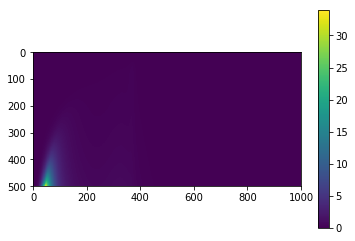

In [4]:
#mass data from O3a LVC population analysis https://dcc.ligo.org/public/0166/P2000077/011/main.pdf

labels = [r"\textsc{Power Law + Peak}"]
filenames = ["Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"]
plpeak_file = "Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json"

mass_1 = np.linspace(3, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)

# Get the posterior on the location of the Gaussian peak of Power Law + Peak
with open(plpeak_file,"r") as jfile:
    plpeak_jf = json.load(jfile)
    
posterior_samples_plpeak = plpeak_jf['posterior']['content']
peak_plp = posterior_samples_plpeak['mpp']
peak_plp_05 = np.quantile(peak_plp,0.05)
peak_plp_95 = np.quantile(peak_plp,0.95)

for i,ff in enumerate(filenames):
       
    f = h5py.File("{0}".format(ff),"r")
        
        # Load mass distribution data
        # "ppd" : A 2D PPD in m1 vs. q space
        # "lines" : A collection of individual m1 and q population distributions
    mass_ppd = f["ppd"][:,:]
    mass_lines = f["lines"]
    index_lines_max=mass_lines["mass_ratio"].shape[0]
    rate_powerlawpeak = np.trapz(np.trapz(mass_ppd, mass_ratio, axis=0),mass_1,axis=0)
        
        # Integrate the 2D PPD over mass ratio to get marginal m1 PPD
    mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
        
        # Get 0.05 and 0.95 percentiles at each m1
    #mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
    #mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
        
        #print(f.keys())
        #print(mass_ppd.shape)
        #plt.scatter(mass_ppd[0,:], mass_ppd[1,:], s=1)
    plt.imshow(mass_ppd)#,  #extent=[0.1,1,3,100]);
    plt.colorbar()
        #plt.xticks(np.arange(3, 100, 10))
    plt.show()   


In [5]:
# Power law + peak mass model (c) from https://dcc.ligo.org/public/0166/P2000077/011/main.pdf
#
def powerlawq(q,beta,mmin,m1,delta_m):
    m2 = m1*q
    if mmin < m2 < m1:
        return q**beta * smoothing(m1*q, mmin, delta_m)
    else:
        return 0
    
def shiftfunc(mp, delta):
    return exp(delta/mp + delta / (mp-delta))

def smoothing(m1, mmin, delta_m):
    if m1 < mmin:
        S = 0 
    elif mmin <= m1 <= mmin + delta_m:
        S = 1./(shiftfunc(m1-mmin,delta_m) + 1)
    elif m1 >= mmin + delta_m:
        S = 1
    return S

def powerlawm1(m1,lam,alpha,mmin,delta_m,mmax,mpp,sigmapp):
    prefpower = (1-lam) * scipy.stats.powerlaw.pdf(1/m1, alpha, 0, mmax) 
    prefpeak = lam * scipy.stats.norm.pdf(m1, mpp, sigmapp)
    S = smoothing(m1, mmin, delta_m)
        
    return S * prefpower * prefpeak

def powerlawpeak_dist(q,m1,lam,alpha,beta,mmin,delta_m,mmax,mpp,sigmapp):
    return powerlawq(q,beta,mmin,m1,delta_m) * powerlawm1(m1,lam,alpha,mmin,delta_m,mmax,mpp,sigmapp)


In [ ]:
# generate population ppd from the pop parameter samples. takes a long time!

samples_pop=plpeak_jf['posterior']['content']
size_samples_pop=len(samples_pop['rate'])
N_pop_samples =1000
sample_inds=np.random.randint(size_samples_pop,size=N_pop_samples)

t = time.process_time()
new_pops = zeros((N_pop_samples,len(mass_ratio),len(mass_1)))

for k in range(N_pop_samples):
    index_p= sample_inds[k]
    firstterms=list(map(lambda x: powerlawm1(x,samples_pop['lam'][index_p],samples_pop['alpha'][index_p],
                                             samples_pop['mmin'][index_p],samples_pop['delta_m'][index_p],
                                             samples_pop['mmax'][index_p],samples_pop['mpp'][index_p],
                                             samples_pop['sigpp'][index_p]), mass_1))
    for i in range(len(mass_1)):
        for j in range(len(mass_ratio)):
            secondterm=powerlawq(mass_ratio[j],samples_pop['beta'][index_p],samples_pop['mmin'][index_p],
                             mass_1[i],samples_pop['delta_m'][index_p])
            new_pops[k,j,i]=firstterms[i]*secondterm

elapsed_time = time.process_time() - t
print(elapsed_time)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [72]:
#test pre-compute

t = time.process_time()
index_p= 0
test = zeros((len(mass_1),len(mass_ratio)))

firstterms=list(map(lambda x: powerlawm1(x,samples_pop['lam'][index_p],samples_pop['alpha'][index_p],
                                             samples_pop['mmin'][index_p],samples_pop['delta_m'][index_p],
                                             samples_pop['mmax'][index_p],samples_pop['mpp'][index_p],
                                             samples_pop['sigpp'][index_p]), mass_1))

for i in range(len(mass_1)):
    for j in range(len(mass_ratio)):
        secondterm=powerlawq(mass_ratio[j],samples_pop['beta'][index_p],samples_pop['mmin'][index_p],
                             mass_1[i],samples_pop['delta_m'][index_p])
        test[i,j]=firstterms[i]*secondterm
        
test = np.transpose(test)
elapsed_time = time.process_time() - t
print(elapsed_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


1.338481999999999


In [50]:
# test casting

#samples_pop=plpeak_jf['posterior']['content']
#size_samples_pop=len(samples_pop['rate'])
#N_pop_samples =100
#sample_inds=np.random.randint(size_samples_pop,size=N_pop_samples)
index_p= 0

t = time.process_time()
test=[[powerlawpeak_dist(x, y,samples_pop['lam'][index_p],samples_pop['alpha'][index_p],samples_pop['beta'][index_p],samples_pop['mmin'][index_p],samples_pop['delta_m'][index_p],samples_pop['mmax'][index_p],samples_pop['mpp'][index_p],samples_pop['sigpp'][index_p])
        for x in mass_ratio] for y in mass_1]
elapsed_time = time.process_time() - t
print(elapsed_time)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


96.09147699999994


In [52]:
#test vect

#samples_pop=plpeak_jf['posterior']['content']
#size_samples_pop=len(samples_pop['rate'])
#N_pop_samples =100
#sample_inds=np.random.randint(size_samples_pop,size=N_pop_samples)
powerlawpeak_dist_v=np.vectorize(powerlawpeak_dist)
index_p= 0

t = time.process_time()
test_v=powerlawpeak_dist_v(mass_ratio[:,np.newaxis], mass_1,samples_pop['lam'][index_p],samples_pop['alpha'][index_p],samples_pop['beta'][index_p],samples_pop['mmin'][index_p],samples_pop['delta_m'][index_p],samples_pop['mmax'][index_p],samples_pop['mpp'][index_p],samples_pop['sigpp'][index_p])
         
elapsed_time = time.process_time() - t
print(elapsed_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


90.68728899999996


In [ ]:
#put rates in an array

rates_pops = []
for i in range(N_pop_samples):
    rates_pops.append(samples_pop['rate'][sample_inds[i]])

In [ ]:
# write to pickle

pickle.dump( new_pops, open( "samples_massmodel_c.pkl", "wb" ) )
pickle.dump( rates_pops, open( "samples_rates_massmodel_c.pkl", "wb" ) )



In [7]:
#read from pickle

new_pops = pickle.load( open( "samples_massmodel_c.pkl", "rb" ) )
rates_pops = pickle.load( open( "samples_rates_massmodel_c.pkl", "rb" ) )


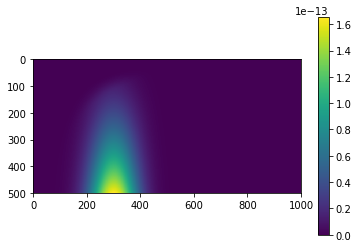

In [74]:
plt.imshow(new_pops[0,:,:])
plt.colorbar()
plt.show() 

In [9]:
import cmath
# we work in geometrized units
Msol = 1.47680000000000000000000000000000000 # in km
c = 1 # we have actually put them to one everywhere in the code already
G = 1
year = 60*60*24*(365.250000000000000000000000000); # s
cc = 2.9980000000000000000000000000000*10**5 # velocity of light in Km/s
pc = 3.0856770000000000000000000000*10**13 # km

H0 = 67.9 # km /s / Mpc # changed to PLANCK 2015
Omegam = 0.306
OmegaL = 0.694
Omegar = 0.

# some useful functions 
def distL(z):
    return (1+z) * integrate.quad(invE,0,z)[0] *cc / H0 *10**6*pc # km

def Ez(z):
    return sqrt(Omegar*(1+z)**4+Omegam*(1+z)**3+OmegaL)

def invE(z):
    return 1. / Ez(z)

def primopezzo(zp):
    return 1/Ez(zp)*(integrate.quad(invE,0,zp)[0])**2

def dVdz(z):
    return 4*pi*(cc/H0)**3*primopezzo(z) # Mpc**3

def dtdf(f,m1,m2):  # Hz, km, km, gravitational wave frequency
    return 5/(96*pi**(8/3))*(1./cc*(m1 + m2)*(m1*m2/(m1 + m2)**2)**(3/5))**(-5/
  3)*f**(-11/3)  # s^2, assuming f in Hz and m in km

def solof(f):
    return f**(-11/3)

def nu(m1,m2):
    return m1*m2/((m1+m2)**2)

def Mc(m1,m2):
    return (m1 + m2) * (m1*m2/((m1+m2)**2))**(3/5)

In [10]:
#here we want to add also the part with the SNR 

# LISA noise parameters
Amp = 5/10*18/10*10**-44
alpha = 138/1000
beta = -221
kappa = 521
gamma = 1680
fk = 113/10**5
L0 = 25/10*10**9
fstar = 1909/100*10**-3
pm = 10**-12

skyav=(4/5*sqrt(2)*sin(pi/3))

# noise function, checked with Mathematica

def Sacc(f):
    return (3*10**-15)**2*(1+(4/10*10**-3/f)**2)*(1+(f/(8*10**-3))**4)

def Sgal(f):
    return Amp*f**(-7/3)*exp(-f**alpha+beta*f*sin(kappa*f))*(1+tanh(gamma*(fk-f)))

def Soms(f):
    return (10. *pm)**2*(1+(2*10**-3/f)**4)  # noi: 10

def Sacc(f):
    return (3*10**-15)**2*(1+(4/10*10**-3/f)**2)*(1+(f/(8*10**-3))**4)
    
def SnSA(f):
    return 10/3*(4*Sacc(f)/(2*pi*f)**4+Soms(f))/(L0**2)*(1+6/10*(f/fstar)**2)

def R(f):
    return 3/20*2

def Sn(f):
    return abs(SnSA(f)+Sgal(f))

def Pn(f): # gravitational wave frequency
    return abs(Sn(f)*R(f))

def Aplus(iota,psi):
    return -(1+cos(iota)**2)*cos(2*psi)-2*cos(iota)*sin(2*psi)

def Across(iota,psi):
    return (1+cos(iota)**2)*sin(2*psi)-2*cos(iota)*cos(2*psi)

def Fplus(theta,phi):
    return 1/2*(1+cos(theta)**2)*cos(2*phi)

def Fcross(theta,phi):
    return cos(theta)*sin(2*phi)

def factorsky(iota,psi,theta,phi):
    return Fplus(theta,phi)*Aplus(iota,psi)+1j*Fcross(theta,phi)*Across(iota,psi)

def factorskySNR(iota,psi,theta,phi):
    return abs(sqrt(2)*sin(pi/3)*(Fplus(theta,phi)*Aplus(iota,psi)+1j*Fcross(theta,phi)*Across(iota,psi)))


In [11]:
# waveform

def ampl(m1,m2,d): 
    return (Mc(m1,m2)*G)**(5/6)*sqrt(5/24)/(pi**(2/3)*d*c**(3/2))
def habs(m1,m2,d,f): # gravitational wave frequency
    return ampl(m1,m2,d)*f**(-7/6)

print(habs(12.4913,12.3884,10.8287*10**6*pc,1./cc))

1.1371737338193066e-14


In [12]:
def fMIN2(fmax0,m1,m2,Tobs): # gravitational wave frequency
    return 1/(1/fmax0**(8/3)+256/5*(Mc(m1,m2)/cc)**(5/3)*pi**(8/3)*(Tobs))**(3/8)

def tofmax(m1,m2,fmin,Tobs): # gravitational wave frequency
    return fmin*((5.*cc)/(5*cc-256*fmin**(8/3)*pi**(8/3)*Tobs*Mc(m1,m2)*(Mc(m1,m2)/cc)**(2/3)))**(3/8)


# gives fmax, given fmin and Tobs. If fmax is above 10 Hz, gives 10 Hz instead. frequency is always in Hz

def getfmax(m1,m2,fmin,Tobs): # gravitational wave frequency
    if fMIN2(1,m1,m2,Tobs)>fmin:
        return tofmax(m1,m2,fmin,Tobs)
    else: 
        return 1
    
def Tmerger(m1,m2,fmin): # gravitational wave frequency
    return 5. * (m1 + m2)**(1./3.) * cc**(5./3.)/ (256. * fmin**(8./3.) * m1 * m2 * pi**(8./3.))

In [13]:
# here we define the SNR; 
# be careful that I have already put the factor for the sky average
# we use the GW only template.

def SNR(iota,psi,theta,phi,fmin,fmax,m1,m2,d): # gravitational wave frequency
    return sqrt(4*integrate.quad(lambda x: (factorskySNR(iota,psi,theta,phi)*habs(m1,m2,d, x/cc))**2/(Pn(x)*(cc**2)), fmin, fmax)[0])
#different noise here!

def SNRAverage(fmin,fmax,m1,m2,d): # gravitational wave frequency
    return sqrt(4*integrate.quad(lambda x: (skyav*habs(m1,m2,d, x/cc))**2/(Pn(x)*(cc**2)), fmin, fmax)[0])


#print(SNR(pi/4,pi/4,pi/4,pi/4,0.01,fmax(30*Msol,10*Msol,0.01,10*year),60*Msol,10*Msol,400*10**6*pc),400*10**6*pc)
#print(SNR(pi/4,pi/4,pi/4,pi/4,0.01,1,10*Msol,20*Msol,10**23))
from scipy.optimize import root_scalar
def findFmin(timemerger,m1,m2):
    def condition(fmin):
        return timemerger-Tmerger(m1,m2,fmin)
    return root_scalar(condition,bracket=(10**-5,1.)).root

def randrate(lamb):
    u = random.random()
    return lamb / np.log(1/u)

In [14]:
# test

z = 0.24716227944027847
tmerger = 5.073762956477287*year
m1 = 88.7
m2 = 64.93
(iota, psi, theta, phi)=2.23353428920549, 5.484427462941964, 2.014813251983311, 2.374251372635906
fmin = findFmin(tmerger,m1,m2)
#print(fmin)
tobs = 6.*year
fmax= getfmax(m1*(1.+z),m2*(1.+z),fmin/(1+z),tobs)
#print(fmax)
loSNR=SNR(iota,psi,theta,phi,fmin/(1+z),fmax,m1*(1+z),m2*(1+z),distL(z))
print(loSNR) # 6.155,9.07

9.071252459562608


In [15]:
# TEST to find the right Gamma distribution for the GW190521-based rate

rateGW190521_median = 0.13
rateGW190521_90 = 0.13+0.30
rateGW190521_10 = 0.13-0.11
k=1

samples=np.random.gamma(k, scale=rateGW190521_median*1.46, size=10000);
print('true:',rateGW190521_median,rateGW190521_90,rateGW190521_10)
print('result:',stat.median(samples),np.percentile(samples, 90),np.percentile(samples, 10))

#k=3 works better with smaller k!

#samples=np.random.gamma(k, scale=rateGW190521_median*0.375, size=10000);
#print('true:',rateGW190521_median,rateGW190521_90,rateGW190521_10)
#print('result:',stat.median(samples),np.percentile(samples, 90),np.percentile(samples, 10))

true: 0.13 0.43 0.020000000000000004
result: 0.13398995405464353 0.44924521231241515 0.021010791064815293


In [21]:
def gendistr(N,iteration,massoption,SNRth):
    

    N=int(N)
    # Define functions to store intermediate products; I haven't decided on the most convenient format for the final catalogs yet...

    #massmin=50*Msol
    #massmax=100*Msol

    # Largest horizon redshift; don't waste computing time above this
    zmax = 0.512
    zmin = 0.1
    # Largest comoving distance for sampling
    #??? dove la usa? -->  cdmax=astropy.cosmology.Planck15.comoving_distance(zmax).value # Mpc
    # z pdf normalization. Comoving volume at largest redshift (because comoving volume at z=0 is 0)
    # Vczhor = (astropy.cosmology.Planck15.comoving_volume(zmax)/astropy.units.Gpc**3).decompose().value #Gpc^3
    # largest merger time (yrs)
    tobs = 10
    # ground-based duty cycle
    dutycycle=1

    data=[]
    for i in range(N):

        #Comoving distance uniform on sphere
        #while True:
        #    cd = np.sum(np.random.uniform(0, cdmax,3)**2)**0.5
        #    if cd<cdmax: break
        # Convert to redshift
        #z = astropy.cosmology.z_at_value(astropy.cosmology.Planck15.comoving_distance,cd*astropy.units.Mpc )
        # Convert to luminosity distance


        z = np.random.uniform(zmin,zmax)
        dl = distL(z)
        
        totalrate={}

        # Mass spectrum (rates in Mpc)
        if massoption=='log': # Log flat distribution in both masses
            bothm=10**np.random.uniform(np.log10(massmin),np.log10(massmax),2)
            m1= max(bothm)
            m2= min(bothm)
            totalrate['median'] = 0.13*10**(-9)
        
        if massoption == 'EOB':
            index = np.random.choice(len(eobdata))
            m1 = Msol*eobdata[index][0]
            m2 = Msol*eobdata[index][1]
            totalrate['median'] = 0.13*10**(-9) 
        if massoption == 'NRconstRate':
            index = np.random.choice(len(NRdata))
            m1 = Msol*NRdata[index][0]
            m2 = Msol*NRdata[index][1]
            totalrate['median'] = 0.13*10**(-9) 
        if massoption == 'NR':
            index = np.random.choice(len(NRdata))
            m1 = Msol*NRdata[index][0]
            m2 = Msol*NRdata[index][1]
            totalrate['median'] = 0.13*10**(-9) 
            totalrate['median'] = np.random.gamma(1, scale=totalrate['median']*1.46); #NEW, only here
        if massoption == 'PHEN':
            index = np.random.choice(len(PHENdata))
            m1 = Msol*PHENdata[index][0]
            m2 = Msol*PHENdata[index][1]
            totalrate['median'] = 0.13*10**(-9) 
            
        if massoption == 'powerlawpeak':
            rate_powerlawpeak = np.trapz(np.trapz(mass_ppd, mass_ratio, axis=0),mass_1,axis=0)
            flat = mass_ppd.flatten()/mass_ppd.flatten().sum()
            sample_index = np.random.choice(a=flat.size, p=flat)
            adjusted_index = np.unravel_index(sample_index, mass_ppd.shape)
            m1 = Msol*mass_1[adjusted_index[1]]
            q = mass_ratio[adjusted_index[0]]
            m2 = m1 * q
            totalrate['median'] = rate_powerlawpeak * 10**(-9) 
            
        if massoption == 'powerlawpeak_cutoff':
            rate_powerlawpeak = np.trapz(np.trapz(mass_ppd, mass_ratio, axis=0),mass_1,axis=0)
            flat = mass_ppd.flatten()/mass_ppd.flatten().sum()
            sample_index = np.random.choice(a=flat.size, p=flat)
            adjusted_index = np.unravel_index(sample_index, mass_ppd.shape)
            m1 = Msol*mass_1[adjusted_index[1]]
            q = mass_ratio[adjusted_index[0]]
            m2 = m1 * q
            if m1>=45*Msol:
                totalrate['median'] = rate_powerlawpeak * 10**(-9) 
            else:
                totalrate['median'] = 0
                
        if massoption == 'powerlawpeak_lines':
            index_lines = np.random.choice(len(new_pops[:,0,0]))
            mass_ppd_i=new_pops[index_lines,:,:]
            flat = mass_ppd_i.flatten()/mass_ppd_i.flatten().sum()
            sample_index = np.random.choice(a=flat.size, p=flat)
            adjusted_index = np.unravel_index(sample_index, mass_ppd_i.shape)
            m1 = Msol*mass_1[adjusted_index[1]]
            q = mass_ratio[adjusted_index[0]]
            m2 = m1 * q
            rate_powerlawpeak_i = rates_pops[index_lines]
            totalrate['median'] = rate_powerlawpeak_i * 10**(-9)
           
        if massoption == 'powerlawpeak_lines_cutoff':
            index_lines = np.random.choice(len(new_pops[:,0,0]))
            mass_ppd_i=new_pops[index_lines,:,:]
            flat = mass_ppd_i.flatten()/mass_ppd_i.flatten().sum()
            sample_index = np.random.choice(a=flat.size, p=flat)
            adjusted_index = np.unravel_index(sample_index, mass_ppd_i.shape)
            m1 = Msol*mass_1[adjusted_index[1]]
            q = mass_ratio[adjusted_index[0]]
            m2 = m1 * q
            rate_powerlawpeak_i = rates_pops[index_lines]
            if m1>=45*Msol:
                totalrate['median'] = rate_powerlawpeak_i * 10**(-9) 
            else:
                totalrate['median'] = 0
        
                 
        
        #if massoption=='powerlaw': # Power law with spectral index alpha in primary; uniform in secondary
        #    alpha=-2.3
        #    m1 = (massmin**(alpha+1.)+np.random.uniform(0.,1.)*(massmax**(alpha+1.)-massmin**(alpha+1.)))**(1./(alpha+1.))
        #    m2 = np.random.uniform(massmin,m1)
        #    totalrate['median'] =  0.13*10**(-9)
            
        # Sky-location, inclination, polarization, initial phase
        cosiota = random.uniform(-1.,1.)
        psi = random.uniform(0,2*pi)
        costheta=random.uniform(-1.,1.)
        phi=random.uniform(0,2*pi)
        iota=np.arccos(cosiota)
        theta=np.arccos(costheta)
        #phic = np.random.uniform(0,2.*np.pi)
        
        # Merger time
        tmaxmerger = 41*year
        tminmerger = 1*year
        tmerger=np.random.uniform(tminmerger,tmaxmerger)
        
        #fmin=np.random.uniform(1e-5,0.01)
        fmin=findFmin(tmerger,m1,m2)
        Fmax= getfmax(m1*(1.+z),m2*(1.+z),fmin/(1.+z),tobs*year)
        #Fmax = 1 #Fmax=1
        snr=SNR(iota,psi,theta,phi,fmin/(1+z),Fmax,m1*(1+z),m2*(1+z),dl)* np.sqrt(dutycycle)


        # Order from Antoine's code:
        # double m1 = atof(argv[1]);
        # double m2 = atof(argv[2]);
        # double costhN = atof(argv[3]);
        # double phiN = atof(argv[4]);
        # double dist = atof(argv[5]);
        # double costhL = atof(argv[6]);
        # double phiL = atof(argv[7]);
        # double tmerger = atof(argv[8]);
        # double phic = atof(argv[9]);

        # Here I pile up together some factors in the rate integral
        #dVcdz = dVdz(z)
        dVcdz = cosmo.comoving_volume(z).value 
        
        rate = totalrate['median'] 
        
        integralbulk = rate * (tmaxmerger - tminmerger)/year/(1.+z) * (zmax-zmin) * dVcdz *np.heaviside(snr-SNRth,0) * dutycycle

        data.append(np.array([m1,m2,z,fmin,integralbulk,snr]))

    return np.array(data).T



In [22]:
def consolidatedistr(Nsingle,iterations,massoption,SNRth):

    Nsingle = int(Nsingle)
    iterations = int(iterations)

    Ntot = Nsingle*iterations
    data=[]
    for it in range(0,iterations):
        data.append(gendistr(Nsingle,it,massoption,SNRth))

    data=np.array(data)

    #[m1,m2,z,pdetLIGO,pdetCE,tmerger,SNR4,SNR10,integralbulk]

    m1 = np.concatenate(data[:,0])
    m2 = np.concatenate(data[:,1])
    z = np.concatenate(data[:,2])
    #pdetLIGO = np.concatenate(data[:,3])
    #pdetCE = np.concatenate(data[:,4])
    #tmerger = np.concatenate(data[:,3])
    fmin = np.concatenate(data[:,3])
    #SNR4 = np.concatenate(data[:,6])
    #SNR10 = np.concatenate(data[:,7])
    integralbulk = np.concatenate(data[:,4])
    SNR10 = np.concatenate(data[:,5])

    return m1,m2,z,fmin,integralbulk,SNR10

In [23]:
def Nevents(bigdata):

    # bigdata is the output of consolidatedistr
    m1,m2,z,fmin,integralbulk,SNR10 = bigdata #consolidatedistr(Nsingle,iterations)

    Ntot = len(m1)

    # The rate is already sampled in gendistr!
    '''
    # Intrisinc merger rate from LIGO O2 catalog. Use the numbers reported in Sec 4 of 1811.12940, which averages over the two pipelines.
    totalrate={}
    if massoption=='powerlaw':
        totalrate['median'] =  0.13*10**(-9)
        totalrate['upper'] = (0.13 + .30)*10**(-9)
        totalrate['lower'] = (57. - 25.)*10**(-9)
    if massoption=='log':
        totalrate['median'] = 0.13*10**(-9)
        totalrate['upper'] = (0.13 + .30)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)
        
    if massoption=='EOB':
        totalrate['median'] = 0.13*10**(-9) 
        totalrate['upper'] = (0.13 + .30)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)
    if massoption=='NR':
        totalrate['median'] = 0.13*10**(-9) 
        totalrate['upper'] = (0.13 + .30)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)
    if massoption=='PHEN':
        totalrate['median'] = 0.13*10**(-9) 
        totalrate['upper'] = (0.13 + .30)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)
    '''

    
    montecarlo_contributions = 1./ Ntot * integralbulk  #* totalrate[rateinterval] 
    

    return np.sum(montecarlo_contributions)



# RESULTS

In [19]:
#OK
# We downloaded the rate per unit mass and mass ratio for the POWER LAW+PEAK model in the O3 population paper
# we then sampled masses and mass ratios from this distribution, and computed m2
# we also computed the rate from the LVC data

# here thr: SNR>8, noise= 10pm, DC =100%, Tobs = 10yrs 

med = Nevents(consolidatedistr(10**4,1,'powerlawpeak',8)) 
print(med)

37.7878028385295


In [151]:
#OK
# out of the events above, we select the once for which m1> 45, to pick out the "AGN binaries"
# ?other ideas on how to make this selection?

med = Nevents(consolidatedistr(10**4,1,'powerlawpeak_cutoff',8)) 
print(med)

16.374484597852316


In [20]:
# TBD
# now including the uncertainity in the mass distribution 1231

med = Nevents(consolidatedistr(10**4,1,'powerlawpeak_lines',8)) 
print(med)

92.83132902640223


In [15]:
# TBD
# and with the cut

med = Nevents(consolidatedistr(10**4,1,'powerlawpeak_lines_cutoff',8)) 
print(med)

18.971516436970745


In [136]:
#DONE

# for reference, this is the rate predicted by GW190521 under the same conditions. 
# note that NR is the waveform model used to compute the GW190521 rate, so it's the most sensible to use here
# !we are yet to include the uncertainity in the rate. a Poisson error in N should be ok..!

med = Nevents(consolidatedistr(10**5,1,'NRconstRate',8)) 
print(med)

6.3369578143962855


In [96]:
# new NR with rate distribution (within Nsingle)

med = Nevents(consolidatedistr(10**5,1,'NR',8)) 
print(med)

9.101961722515517


### Tests misc

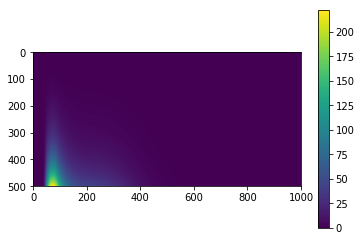

26.83733995309088 26.563489545406274


In [232]:
index_lines_max=mass_lines["mass_ratio"].shape[0]
index=800
mass_ppd_1=np.outer(mass_lines["mass_ratio"][index_lines],mass_lines["mass_1"][index_lines])

plt.imshow(mass_ppd_1)#,  #extent=[0.1,1,3,100]);
plt.colorbar()
plt.show() 

realrate=np.trapz(mass_lines["mass_ratio"][index],mass_ratio)
realrate2=np.trapz(mass_lines["mass_1"][index],mass_1)
print(realrate,realrate2)


In [105]:
# sample from numerical dist
rate_powerlawpeak = np.trapz(np.trapz(mass_ppd, mass_ratio, axis=0),mass_1,axis=0)
print('rate:',rate_powerlawpeak)

# Create a flat copy of the array (https://stackoverflow.com/questions/56017163/given-a-2d-numpy-array-representing-a-2d-distribution-how-to-sample-data-from-t)
flat = mass_ppd.flatten()/mass_ppd.flatten().sum()


# Then, sample an index from the 1D array with the
# probability distribution from the original array
sample_index = np.random.choice(a=flat.size, p=flat)

# Take this index and adjust it so it matches the original array
adjusted_index = np.unravel_index(sample_index, mass_ppd.shape)
#print(mass_1[adjusted_index[1]], mass_ratio[adjusted_index[0]] )


9.893893893893894 0.7691382765531062


In [44]:
m1samples= [] 
qsamples = []
for i in range(6300):
    flat = mass_ppd_norm.flatten()/mass_ppd_norm.flatten().sum()
    sample_index = np.random.choice(a=flat.size, p=flat)
    adjusted_index = np.unravel_index(sample_index, mass_ppd.shape)
    m1 = mass_1[adjusted_index[1]]
    q = mass_ratio[adjusted_index[0]]
    m1samples.append(m1)
    qsamples.append(q) 
    

In [43]:
samplesAndrea = np.loadtxt('samples_ary.txt')
len(samplesAndrea)

6300

In [84]:
m1_ppd=np.sum(mass_ppd,axis=0)*(mass_ratio[1]-mass_ratio[0])/np.sum(mass_ppd_norm)

Text(0, 0.5, '$p(m1)$')

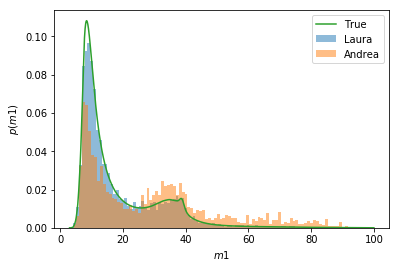

In [89]:
plt.hist(m1samples,100,alpha=0.5,density=True,label='Laura')
plt.hist(samplesAndrea[:,1],100,alpha=0.5,density=True,label='Andrea')
plt.plot(mass_1,m1_ppd,label='True')
plt.xlabel(r"$m1$")
plt.legend()
plt.ylabel(r"$p(m1)$")
#plt.gca().set_yticks([]);

Text(0, 0.5, 'm1')

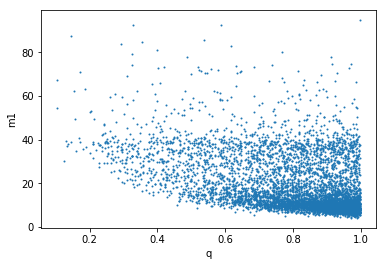

In [45]:
plt.scatter(qsamples, m1samples, s=1)
plt.xlabel('q')
plt.ylabel('m1')

Text(0, 0.5, 'm1')

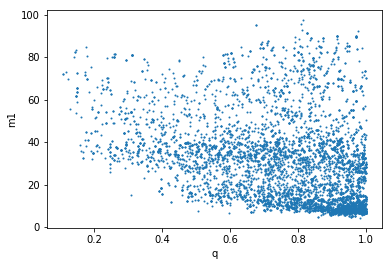

In [46]:
plt.scatter(samplesAndrea[:,0], samplesAndrea[:,1], s=1)
plt.xlabel('q')
plt.ylabel('m1')

In [4]:
#mass_ppd.shape
#mass_and_ratio = np.zeros(mass_ppd.shape)#,dtype=tuple)
#for i in range(mass_ppd.shape[0]):
#    for j in range(mass_ppd.shape[1]):
#        mass_and_ratio[i,j] = mass_ratio[i]*mass_1[j]

In [97]:
#flat = mass_ppd.flatten()/np.trapz(np.trapz(mass_ppd, mass_ratio, axis=0), mass_1, axis=0)
#mass_ppd_norm = np.zeros(mass_ppd.shape)#,dtype=tuple)

#for i in range(mass_ppd.shape[0]-1): #ratio
#    for j in range(mass_ppd.shape[1]-1): #m1
#        if i<mass_ppd.shape[0]:
#            mass_ppd_norm[i,j] = mass_ppd[i,j] * (mass_ratio[i+1]-mass_ratio[i])
#        else:
#            mass_ppd_norm[i,j] = mass_ppd[i,j] * 0
#        if j<mass_ppd.shape[1]:
#            mass_ppd_norm[i,j] = mass_ppd_norm[i,j] * (mass_1[j+1]-mass_1[j])
#        else:
#            mass_ppd_norm[i,j] = mass_ppd_norm[i,j] * 0 



24.87981296458682
